# Single qubit Ising Model



<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
nonlinearxwaves@gmail.com<br>


@created 18 july 2022<br>
@version 24 july 2022

In [1]:
from thqml import quantummap
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
np.set_printoptions(precision=2)

2022-08-17 19:11:31.941826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 19:11:31.941852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-17 19:11:33.225315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 19:11:33.225334: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 19:11:33.225351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2022-08-17 19:11:33.225551: I tensorflow/core/platform/cpu_feature_guard.c

# Define Hamiltonian operator

In [2]:
@tf.function
def Hamiltonian(J=1.0,h=0.0):
    """ single qubit tranverse Ising model Hamiltonian
    
        H=-J Z-h X
        
        Params
        ------
        h = field/gap (positive)
        J = Z coefficient (positive)
    """
    out =-J*quantummap.Zsingle -h*quantummap.Xsingle
        
    return out

## Test the Hamiltonian

In [3]:
H=Hamiltonian()
print(H)

tf.Tensor(
[[-1.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j]], shape=(2, 2), dtype=complex64)


In [4]:
H=Hamiltonian(J=1.0,h=1.0)
print(H)

tf.Tensor(
[[-1.+0.j -1.+0.j]
 [-1.+0.j  1.-0.j]], shape=(2, 2), dtype=complex64)


# Variational ansatz (feature map nqubits=1)

In [5]:
@tf.function
def FeatureMapU(theta, psi=quantummap.qubit0):
    """ feature map with 1 qubits 
    
        Hadamard and rotation
        
        Exp( theta(0) X)Exp(theta(1)*Y)Exp(theta(2)*Z)H|0\rangle
    
        Params
        ------
        theta[0] : rotation in the X
        theta[1] : rotation in the Y
        theta[2] : rotation in the Z
    
    """
    thetaX=theta[0]
    thetaY=theta[1]
    thetaZ=theta[2]
    psi=quantummap.Gate1(quantummap.Hsingle,psi)
    psi=quantummap.Gate1(quantummap.EX(thetaX),psi)
    psi=quantummap.Gate1(quantummap.EY(thetaY),psi)
    psi=quantummap.Gate1(quantummap.EZ(thetaZ),psi)
    
    return psi

## Test the feature map

Define a vector of parameters

In [6]:
theta=[2.0,0.0,1.0]

Print the feature map at theta

In [7]:
print(FeatureMapU(theta))

tf.Tensor([-0.7 +0.1j  0.38+0.6j], shape=(2,), dtype=complex64)


# Layer with weights theta and output mean Hamiltonian

In [8]:
class HamiltonianLayer(tf.keras.layers.Layer):
    # Define a Layer returning the mean value of the Hamiltonian
    # on the variational ansatz
    #
    # The layer has a trainable parameters the 
    # parameters theta of the trainable feature map
    # theta[0] as theta_x
    # theta[1] as theta_y
    # theta[2] as theta_z
    #
    # The Layer use the functions
    # Hamiltonian
    # FeatureMapU
    #
    # The constructor use parameters 
    #
    #  Params
    #  ------
    #  J : positive Z coefficinet
    #  h : positive field 
    #
    #  Example
    #  -------
    #  HL=HL(J=.5, h=1.2)
    #
    #  The call return the real part of 
    #  <\psi|H\psi>
    #
    def __init__(self, J=1.0, h=0.0, **kwargs):
        super(HamiltonianLayer, self).__init__(**kwargs)
        # trainable parameter of the model
        # initially set as random (real variables)
        self.theta=tf.Variable(np.random.random(3),
                               dtype=tf.float32,
                              name='theta')
        # gap coefficient
        self.J=J
        # field coefficient
        self.h=h
        # Hamiltonian
        self.H=Hamiltonian(J=self.J,h=self.h)
        # Feature map for the ground state
        self.FeatureMap=FeatureMapU
    def ground_state(self):
        """ Return the current ground state """
        psi=self.FeatureMap(self.theta,quantummap.qubit0)
        return psi
    def call(self,dummy):
        """ Return Re<H> 
        Remark:  this layer has a dummy variable as input
        (required for compatibility with tensorflow call)
        """
        #psi=self.FeatureMap(self.theta,quantummap.qubit0)
        psi=self.ground_state()
        meanH=quantummap.Scalar(psi, 
                                quantummap.Gate1(self.H, psi))
        return tf.math.real(meanH)

## test the layer

create a layer with a name scope

In [9]:
HL=HamiltonianLayer()

print the parameters of the Hamiltonian

In [10]:
print([HL.J, HL.h])

[1.0, 0.0]


print the Hamiltonian

In [11]:
print(HL.H)

tf.Tensor(
[[-1.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j]], shape=(2, 2), dtype=complex64)


Print the randomly generated ground state

In [12]:
print(HL.ground_state())

tf.Tensor([0.88+0.24j 0.41+0.05j], shape=(2,), dtype=complex64)


print the weights

In [13]:
tf.print(HL.weights)

[[0.190203294 0.36212182 0.0753245801]]


In [14]:
print(HL.weights)

[<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([0.19, 0.36, 0.08], dtype=float32)>]


the weights correspond to the variable theta

In [15]:
print(HL.theta)

<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([0.19, 0.36, 0.08], dtype=float32)>


In [16]:
HL(0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.66]], dtype=float32)>

# Define and train the model

In [17]:
# hyperparameter for the Hamiltonain
J=1.0
h=1.7
# Input layer (one dummy input)
xin = tf.keras.layers.Input(1);
# Hamiltonianl layer
HL=HamiltonianLayer(J=J,h=h)
# output
meanH=HL(xin)
# trainable model returning meanH
Ising = tf.keras.Model(inputs = xin, outputs=meanH)

## Test the model

In [18]:
tf.print(Ising(2.5))

[[-0.966065824]]


## Add loss function

In [19]:
# add loss function
Ising.add_loss(meanH)

## Summary of the model

In [20]:
Ising.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 hamiltonian_layer_1 (Hamilt  (1, 1)                   3         
 onianLayer)                                                     
                                                                 
 add_loss (AddLoss)          (1, 1)                    0         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Plot model

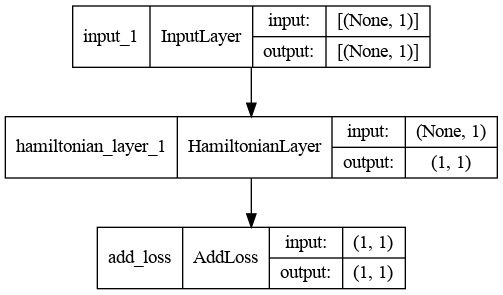

In [21]:
from keras.utils.vis_utils import plot_model
# save as pdf
plot_model(Ising, to_file='singlequbitIsing_plot.pdf', show_shapes=True, show_layer_names=True)
# save and display as png
plot_model(Ising, to_file='singlequbitIsing_plot.png', show_shapes=True, show_layer_names=True)

## Store the ground state before training

In [22]:
ground_state_0=tf.identity(HL.ground_state())
print(ground_state_0)

tf.Tensor([0.67+0.65j 0.3 -0.2j ], shape=(2,), dtype=complex64)


## Store the weights before training

In [23]:
weight0=tf.identity(Ising.weights)
print(weight0)

tf.Tensor([[0.09 0.42 0.69]], shape=(1, 3), dtype=float32)


## Train

In [24]:
import tqdm
tqdm.__version__

'4.64.0'

In [25]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False)

In [26]:
Ising.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [27]:
history = Ising.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])

Training:   0%|                                       0/1000 ETA: ?s,  ?epochs/s

In [28]:
Ising.weights

[<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([2.76e-01, 2.66e-01, 1.04e-08], dtype=float32)>]

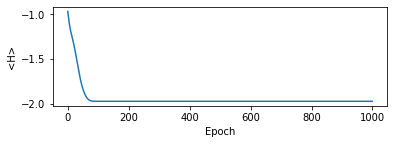

In [29]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('<H>')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingIsing1.pdf", format="pdf", bbox_inches="tight")

Final value for the mean Hamiltonian

In [30]:
print(history.history['loss'][-1])

-1.9723085165023804


Theoretical value for the eigenvalue

In [31]:
-np.sqrt(J**2+h**2)

-1.972308292331602

## Ground state after training

In [32]:
ground_state=HL.ground_state()
tf.print(tf.math.real(ground_state).numpy())
tf.print(tf.math.imag(ground_state).numpy())
print(HL.ground_state().numpy())

array([0.84, 0.48], dtype=float32)
array([0.24, 0.14], dtype=float32)
[0.84+0.24j 0.48+0.14j]


In [33]:
ev=HL.ground_state().numpy()
print(ev)

[0.84+0.24j 0.48+0.14j]


In [34]:
ev/ev[1]

array([1.75+0.j, 1.  +0.j], dtype=complex64)

In [35]:
# theoretical value of the first component
(J+np.sqrt(J**2+h**2))/h

1.7484166425480012

In [36]:
# check if gound state is normalized
quantummap.Scalar(ground_state,ground_state)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[1.+0.j]], dtype=complex64)>

In [37]:
# ground state before training
print(ground_state_0)

tf.Tensor([0.67+0.65j 0.3 -0.2j ], shape=(2,), dtype=complex64)


In [38]:
Ising.weights[0]

<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([2.76e-01, 2.66e-01, 1.04e-08], dtype=float32)>

In [39]:
# weights before training
weight0

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.09, 0.42, 0.69]], dtype=float32)>

In [40]:
HL.theta

<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([2.76e-01, 2.66e-01, 1.04e-08], dtype=float32)>

In [41]:
psi=FeatureMapU(Ising.weights[0],quantummap.qubit0)
print(psi)

tf.Tensor([0.84+0.24j 0.48+0.14j], shape=(2,), dtype=complex64)


In [42]:
HL.theta

<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([2.76e-01, 2.66e-01, 1.04e-08], dtype=float32)>

In [43]:
HL.weights

[<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([2.76e-01, 2.66e-01, 1.04e-08], dtype=float32)>]

In [44]:
HL(0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.97]], dtype=float32)>